## 2. (Deep) CNNs for Image Colorization

In [1]:
import sys
import os
import numpy as np
import keras
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from keras.models import Sequential
from keras.layers import Dropout, MaxPooling2D, Conv2D, Dense
from keras.datasets import cifar10


Using TensorFlow backend.


## (a) This assignment uses a convolutional neural network for image colorization which turns a grayscale image. By converting an image to grayscale, we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Download the dataset.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

## (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [4]:
def extractBird(x, y):
    idx = [i for i, j in enumerate(y) if j == 2]
    return x[idx], y[idx]

In [5]:
x_train, y_train = extractBird(x_train, y_train)
x_test, y_test = extractBird(x_test, y_test)
num_train = len(x_train)
num_test = len(x_test)

bird_set = np.vstack((x_train, x_test))

In [6]:
print('number of images :', len(bird_set))
print(bird_set[0].shape)
#print(bird_set[2])
print('number of train data: ', num_train, '\nnumber of test data: ', num_test)

number of images : 6000
(32, 32, 3)
number of train data:  5000 
number of test data:  1000


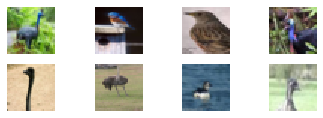

In [7]:
for i in range(0, 8):
  axis = plt.subplot(4, 4, i+1)
  arr = bird_set[i]
  axis.imshow(arr)
  plt.axis('off')
plt.show()

## (c) Those 6000 images have 6000 x 32 x 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

In [8]:
# Convert to floats instead of the integer coding. Dividing by 255 to make
# integers be in the range [0-1]
bird_set_normal = np.array(bird_set, dtype=np.float64) / 255


# Load image and transform to a 2D numpy array.
image_array = []
for i in range(len(bird_set_normal)):
  x, y, z = bird_set_normal[i].shape
  image_array.append(bird_set_normal[i].reshape(x*y, z))
print(image_array[1].shape)
print(len(image_array))
print(image_array[0])



(1024, 3)
6000
[[0.64313725 0.80784314 0.32941176]
 [0.41176471 0.54901961 0.23921569]
 [0.4627451  0.58039216 0.39607843]
 ...
 [0.36862745 0.5254902  0.11372549]
 [0.35686275 0.52156863 0.10196078]
 [0.47843137 0.66666667 0.17254902]]


In [9]:
image_array = np.reshape(image_array, (len(image_array)*image_array[0].shape[0], 3))

In [10]:
print(image_array.shape)
print(image_array)

(6144000, 3)
[[0.64313725 0.80784314 0.32941176]
 [0.41176471 0.54901961 0.23921569]
 [0.4627451  0.58039216 0.39607843]
 ...
 [0.61176471 0.70196078 0.37254902]
 [0.61960784 0.70588235 0.38431373]
 [0.61568627 0.70196078 0.38431373]]


In [11]:
print('number of pixels: ', image_array.shape[0])

number of pixels:  6144000


## (d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel's value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [12]:
n_colors = 4

# randomization
image_array_sample = shuffle(image_array)

# initial centroid
#init_centroid = np.array([[0, 0, 128],
#                     [230, 25, 75],
#                     [170, 255, 195],
#                     [255, 255, 255]],
#                    np.float64) / 255
# fit model
kmeans = KMeans(n_clusters=n_colors, n_jobs=20).fit(image_array_sample)
#kmeans = KMeans(n_clusters=n_colors, n_jobs=20, init=init_centroid).fit(image_array_sample)




In [13]:
# Get labels for all points

centers = kmeans.cluster_centers_
labels = kmeans.predict(image_array)

In [14]:
print('centers\n', centers)

centers
 [[0.42474526 0.42352956 0.32243631]
 [0.80858584 0.82924217 0.82782437]
 [0.61113257 0.60816639 0.52878694]
 [0.19056469 0.19442389 0.14994796]]


In [15]:
print('labels\n', labels, labels.shape)

labels
 [2 0 0 ... 2 2 2] (6144000,)


In [16]:
image_array.shape[0]

6144000

In [17]:
# Convert colored images to k-color images by converting each pixel's value to 
# the closest main color
clustered_image = []
for i in range(image_array.shape[0]):
  clustered_image.append(centers[labels[i]])

clustered_image = np.array(clustered_image)
print(clustered_image.shape)

(6144000, 3)


In [18]:
print('converted pixels')
clustered_image[0:10]

converted pixels


array([[0.61113257, 0.60816639, 0.52878694],
       [0.42474526, 0.42352956, 0.32243631],
       [0.42474526, 0.42352956, 0.32243631],
       [0.61113257, 0.60816639, 0.52878694],
       [0.61113257, 0.60816639, 0.52878694],
       [0.61113257, 0.60816639, 0.52878694],
       [0.61113257, 0.60816639, 0.52878694],
       [0.80858584, 0.82924217, 0.82782437],
       [0.80858584, 0.82924217, 0.82782437],
       [0.61113257, 0.60816639, 0.52878694]])

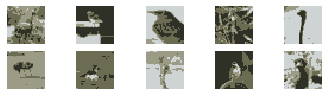

In [19]:
temp_kmeans = np.array(clustered_image).reshape((6000, 32, 32, 3))

for i in range(0, 10):
  axis = plt.subplot(5, 5, i+1)
  arr = temp_kmeans[i]
  axis.imshow(arr)
  plt.axis('off')
plt.show()

## (e) Use any tool to obtain grayscale 32x32x1 images from the original 32x32x3 images. The grayscale images are inputs of your network.


In [20]:
# Convert to grayscale
#bird_set = bird_set.reshape((6000, 32, 32, 3))
gray_bird_set = []
for i in range(len(bird_set)):
  gray_bird_set.append(rgb2gray(bird_set[i]))
  
#print(gray_bird_set[0].shape)


In [21]:
gray_bird_set = np.array(gray_bird_set)
print(gray_bird_set.shape)
#x_train = gray_bird_set[0:num_train]
#y_train = y_N[0:num_train]
#x_test = gray_bird_set[-num_test:]
#y_test = y_N[-num_test:]
#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)

(6000, 32, 32)


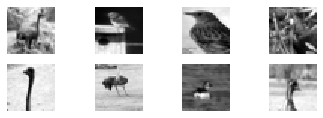

In [22]:
for i in range(0,8) :
  axis = plt.subplot(4, 4, i+1)
  #arr = temp_gray[i]
  arr = gray_bird_set[i]
  axis.imshow(arr,cmap='gray')
  #axis.imshow(arr)
  plt.axis('off')
plt.show()

In [23]:
gray_bird_set = gray_bird_set.reshape((6000, 32, 32, 1))

In [24]:
gray_bird_set

array([[[[0.73834824],
         [0.49751608],
         [0.54210314],
         ...,
         [0.52388078],
         [0.52191647],
         [0.45385804]],

        [[0.76048667],
         [0.55939961],
         [0.37795647],
         ...,
         [0.50821647],
         [0.50623725],
         [0.44658039]],

        [[0.67089373],
         [0.67845412],
         [0.57879843],
         ...,
         [0.50038039],
         [0.42305804],
         [0.40148588]],

        ...,

        [[0.55394824],
         [0.57410745],
         [0.57051412],
         ...,
         [0.45801922],
         [0.50283176],
         [0.61262078]],

        [[0.60032863],
         [0.61078549],
         [0.60721412],
         ...,
         [0.44091922],
         [0.50451333],
         [0.61878235]],

        [[0.61058   ],
         [0.69006431],
         [0.58865333],
         ...,
         [0.46246863],
         [0.4563149 ],
         [0.59104078]]],


       [[[0.02314863],
         [0.02314863],
         [0.02

## (f) Set up a deep convolutional neural network with two convolution layers (or more) and two ( or more) MLP layers. Use 5 x 5 filters and a softmax output layer. Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Use a classification scheme, which means your output must determine one of the k = 4 color classes for each pixel in your grayscale image. Your input is a grayscale version of an image (32x32x1) and the output is 32x32x4. The output assigns one of the k = 4 colors to each of the 32x32 pixels; therefore, each of the pixels is classified into one of the main colors, the RGB code of that color can be assigned to the pixel. For example, if the third main color is [255 255 255] and pixel (32,32) of an image has the one-hot encoded class [ 0 0 1 0 ], ie. it was classified as the third color, the (32, 32) place in the output can be associated with [255 255 255]. The size of the output of the convolutional part, c1 x c2 depends on the size of the convolutional layers you choose and is a feature map, which is a matrix. That matrix must be flattened or reshaped, i.e. must be turned into a vector of size c1c2x1, before it is fed to the MLP part. Choose the number of neurons in the first layer of the MLP(and any other hidden layers, if you are willing to have more than one hidden layer) yourself, but the last layer must have 32x32x4 = 4096 neurons, each of which represents a pixel being in one of the k = 4 classes. Add a softmax layer which will choose the highest value out of its k = 4 inputs for each of the 1024 pixels; therefore the output of the MLP has to be reshaped into a 32x32x4 matrix, and to get the colored image, the RGB vector of each of the k = 4 classes has to be converted to the RGB vector, so an output image will be 32x32x3. Train at least for 5 epochs (30 epochs is strongly recommended)  Plot training, and (validation) test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

In [25]:
# hot encoding
y_N = keras.utils.to_categorical(labels).reshape((6000, 32, 32, 4))
y_N[0][0][0]

array([0., 0., 1., 0.], dtype=float32)

In [26]:
gray_bird_set.shape, y_N.shape

((6000, 32, 32, 1), (6000, 32, 32, 4))

In [27]:
x_train = gray_bird_set[0:num_train]
y_train = y_N[0:num_train]
x_test = gray_bird_set[-num_test:]
y_test = y_N[-num_test:]

In [28]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5000, 32, 32, 1), (5000, 32, 32, 4), (1000, 32, 32, 1), (1000, 32, 32, 4))

In [29]:
# set parameters
num_filter_1 = 64
num_filter_2 = 128
filter_size = (5,5)
act = 'softmax'
stride = (1, 1)
padding = 'same'
num_neurons = 32
num_epoch = 100

print('number of filters: ', num_filter_1)
print('output layer activation: ', act)
print('stride: ', stride)
print('padding: ', padding)
print('epoch: ', num_epoch)

number of filters:  64
output layer activation:  softmax
stride:  (1, 1)
padding:  same
epoch:  100


In [30]:
# build a model
cnn = Sequential()
cnn.add(Conv2D(num_filter_1 , kernel_size = filter_size, strides = stride, padding = padding, input_shape = (32, 32, 1)))
#cnn.add(Conv2D(num_filter_1 , kernel_size = filter_size, strides = stride, padding = padding, activation ='relu', input_shape = (32, 32, 1)))
cnn.add(MaxPooling2D(pool_size = (2,2), strides = stride, padding = padding))
cnn.add(Conv2D(num_filter_1 , kernel_size = filter_size, strides = stride, padding = padding))
cnn.add(MaxPooling2D(pool_size = (2,2), strides = stride, padding = padding))
cnn.add(Dense(num_neurons, activation = 'softmax'))
cnn.add(Dense(4, activation = 'softmax'))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
_________________________________________________________________


In [31]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
history = cnn.fit(x_train, y_train, epochs=num_epoch, validation_split=0.1)

Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 30s 7ms/step - loss: 1.2415 - acc: 0.5036 - val_loss: 1.1633 - val_acc: 0.6092
Epoch 2/100
4500/4500 [==============================] - 29s 7ms/step - loss: 1.1405 - acc: 0.6002 - val_loss: 1.0971 - val_acc: 0.6236
Epoch 3/100
4500/4500 [==============================] - 30s 7ms/step - loss: 1.0799 - acc: 0.6281 - val_loss: 1.0489 - val_acc: 0.6501
Epoch 4/100
4500/4500 [==============================] - 30s 7ms/step - loss: 1.0261 - acc: 0.5419 - val_loss: 0.9838 - val_acc: 0.5708
Epoch 5/100
4500/4500 [==============================] - 29s 7ms/step - loss: 0.9822 - acc: 0.5496 - val_loss: 0.9439 - val_acc: 0.5809
Epoch 6/100
4500/4500 [==============================] - 32s 7ms/step - loss: 0.9516 - acc: 0.5527 - val_loss: 0.9263 - val_acc: 0.5850
Epoch 7/100
4500/4500 [==============================] - 32s 7ms/step - loss: 0.9236 - acc: 0.5586 - val_loss: 0.8991 - val_acc: 0.5773
E

In [32]:
def getError(n):
  return 1-n

train_errors = map(getError, history.history['acc'])
val_errors = map(getError, history.history['val_acc'])

train_err = list(train_errors)
val_err = list(val_errors)

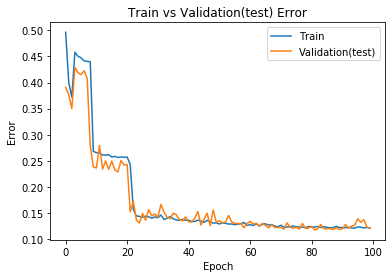

In [33]:
plt.plot(train_err)
plt.plot(val_err)
plt.title('Train vs Validation(test) Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation(test)'], loc='upper right')
plt.show()

In [34]:
prediction = cnn.predict(x_test)

In [35]:
a, b, c, d = prediction.shape
prediction = prediction.reshape((a*b*c, d))

In [36]:
#prediction.shape

In [37]:
pred = prediction[:, 0:3]
#pred.shape

In [38]:
for i in range(len(prediction)):
  pred[i] = kmeans.cluster_centers_[np.argmax(prediction[i])]

In [39]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Train Errors:', train_err, '\n')
print('last Train Error', train_err[-1])
print('average Train Error', np.array(train_err).mean())
print('lowest Train Error', np.array(train_err).min())
print('Test Error :', 1 - score[1])

Train Errors: [0.49639040803909307, 0.39975694433848064, 0.37190451383590695, 0.4580907118055556, 0.4504164495468139, 0.44727864572736953, 0.4414192708333333, 0.4406078558497959, 0.4396174045668708, 0.26799826383590697, 0.26550889762242635, 0.2650909289254083, 0.26103819433848063, 0.26075629350874163, 0.26174392355812925, 0.25715429676903623, 0.2584264321857028, 0.2563320313029819, 0.2572688802083334, 0.2565455729166667, 0.25719357649485275, 0.242779513835907, 0.15652777767181392, 0.14415646701388884, 0.14339930560853742, 0.14161436642540826, 0.14370638026131521, 0.14243098947736954, 0.13994140619701811, 0.14217209196090697, 0.14073437499999997, 0.14595399310853752, 0.1373676214218139, 0.13978298621707497, 0.1430744357638889, 0.13861349821090696, 0.13644921885596384, 0.13569140624999998, 0.13755251730812923, 0.1358943141301473, 0.13614344628651942, 0.13328146696090704, 0.13378407118055557, 0.13603797737757362, 0.13435828982459175, 0.1319822049670749, 0.1357215710745917, 0.1326966144773

original


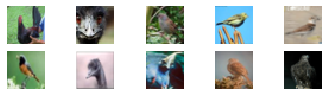

In [40]:
for i in range(0, 10):
  axis = plt.subplot(5, 5, i+1)
  arr = bird_set[5000 + i]
  axis.imshow(arr)
  plt.axis('off')
print('original')
plt.show()

grayscale input


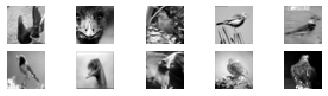

In [41]:
# grayscale input

for i in range(0,10):
    axis = plt.subplot(5,5,i+1)
    arr = x_test.reshape((1000,32,32))[i]
    #arr = tp[i]
    axis.imshow(arr,cmap='gray')
    plt.axis('off')
print('grayscale input')
plt.show()

predicted one


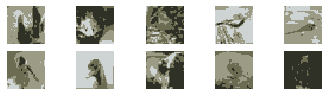

In [43]:
### pred = pred.reshape((1000, 32, 32, 3))

for i in range(0,10):
    axis = plt.subplot(5,5,i+1)
    arr = pred[i]
    axis.imshow(arr)
    plt.axis('off')
print('predicted one')
plt.show()